# Radiolysis simultions

Making figures for my thesis - radiolysis simulations of H2O and H2O-NaCl. 

This code and the parameters (reactions etc) were taken from Birk Fritsch and colleagues (https://github.com/BirkFritsch/Radiolysis-simulations, DOI: 10.1021/acs.jpclett.3c00593). 



## Define functions 

These are the funtions from the github linked above. I have made slight alterations to avoid it automatically plotting the data and a few other bits and pieces.


In [8]:

import re
import logging
import numpy as np
import pandas as pd
from scipy.constants import N_A, e
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from datetime import datetime
from itertools import cycle
from decimal import Decimal
import seaborn as sns

logging.basicConfig(level=logging.WARNING)



def e_flux_to_dose_rate(flux, thickness, stopping_power = 2.36, mean_free_path=3.8e-7,t=1):
    """
    INPUT:
    
    flux (float or array-like) in e/(Angstroem²s)
    Thickness (float or array-like) in m
    Mean free path (float or array-like) in m
    stopping_power (float or array-like) in MeV(cm)²/g
    
    RETURN:
    
    dose rate (float or array-like) in Gy/s 
    """

    dose_rate = 1e5 * e* (stopping_power/(1e-20*t)) * flux * (1 + thickness/mean_free_path)
    
    return dose_rate



def _extract_prefix(string, re_object):
    """
    Function to extract the prefix of a reactant based on regular expressions

    Parameters
    ----------
    string : str
        A string containing the reactant and an optional prefix in float syntax.
    re_object : re.Pattern object
        

    Returns
    -------
    prefix : float
        
    reactant : str

    """
    #match regular expression to string
    re_result = re_object.search(string)
    #if re_result is not None, this will be truthy
    if re_result:
        #split prefix and reactant
        try:
            prefix, reactant = string.split()
        except ValueError as v:
            logging.critical(f'ValueError for {string}. This means, no patterb are found, although expected by the regular expression.')
            raise v
        #convert prefix to float
        prefix = float(prefix)
    
    else:
        #dummy prefix for later calculation
        prefix = 1.
        #remove spaces
        reactant = string.split()[0]
    
    return prefix, reactant



def create_reactions(filename):
    """
    Dechifre a reaction file. Every line in the file specified is interpretated
    as reaction. Educt and product site are separated by '-->'. The rate constant
    is separated from the reaction by a semi colon.
    Example:
        
        2 A + 4 B --> 2 AB- + 2 B+ ; 0.35
        
        this would return the following:
            np.array([0.35]), {0:{'educts':['A', 'B'], 'products':['AB-', 'B+'], 'educt prefix':np.array([2.,4.]), 'product prefix':np.array([2.,2.]),}}
        
    Parameters
    ----------
    filename : str
        Name of the file containing reaction equations and rate constants. The default is 'reactions.txt'.

    Returns
    -------
    rate_constants : numpy.ndarray
        Extracted rate constant in order of appearance.
    reaction_map : dict
        Nested dictionary:
            For every reaction a dictionary with the keys 'educts, products, educt prefix, product prefix' is created.
            educts, products -> lists containing strings
            educt prefix, product prefix -> np.ndarrays containing floats
            
            The key for this sub_dictionary is an integer based on the order of apperance.

    """
    #read reaction file
    
    with open(filename) as reaction_file:
        #create a list with every line in file as string
        reaction_list = reaction_file.readlines()

    #create output containers
    rate_constants = np.zeros(len(reaction_list))
    reaction_map = {}
    
    #define re.Pattern object for prefix extraction
    find_prefix = re.compile('^\s?\d+\.?\d*\s+')
    
    #do the work
    for n, reaction in enumerate(reaction_list):
        
        #replace tabs by spaces:
        reaction = ' '.join(reaction.split('\t'))
        
        #divide reaction into two sides based on reaction marker
        try:
            educt_site, product_site = reaction.split('-->')
        except ValueError as v:
            logging.critical(f'Could not handle the reaction file in line {n}: {reaction}. I skip line {n} and continue.')
            raise v
        #split the rate constant k off the product site
        product_site, *k = product_site.split(';')
        #store k
        try:
            rate_constants[n] = float(k[0])
        except ValueError:
            logging.error(f'Could read the rate constant in line {n}: {reaction}. It is set to 0, which effectively disables the reaction.')
            rate_constants[n] = 0.
        #split product and educt sites into individual reactants
        raw_educts = educt_site.split(' + ')
        raw_products = product_site.split(' + ')
        
        #create output containers for sub dictionary
        educts = []
        products = []
        educt_prefix = np.ones(len(raw_educts))
        product_prefix = np.ones(len(raw_products))
        
        #get prefixes for every reactant
        for m, educt in enumerate(raw_educts):
            prefix, reactant = _extract_prefix(educt, find_prefix)
            educts.append(reactant)
            educt_prefix[m] = prefix
        
        for m, product in enumerate(raw_products):
            prefix, reactant = _extract_prefix(product, find_prefix)
            products.append(reactant)
            product_prefix[m] = prefix
        
        #store results
        reaction_map[n] = {
                           'educts':educts,
                           'products':products,
                           'educt prefix':educt_prefix,
                           'product prefix':product_prefix,
                           }
        
    
    return rate_constants, reaction_map



def _make_reactant_set(reaction_map):
    """
    Create a set containing every species as string

    Parameters
    ----------
    reaction_map : dict
        nested dictionary, as returned by create_reactions
    

    Returns
    -------
    reactant_set : unique list

    """
    reactant_set = set()
    
    for n in reaction_map:
        for site in ('educts', 'products'):
            for reactant in reaction_map[n][site]:
                reactant_set.add(reactant)
                
    return sorted(list(reactant_set))
        


def get_initial_concentrations(concentration_set, concentrations='Water_concentrations and gvalues.txt',
                               sep=None, default_concentration = 0., default_gval=0.):
    """
    Create a dictionary with the initial concentrations and g values given in a file

    Parameters
    ----------
    concentration_set : iterable
        Iterable object containing a preferably unique list of the required species names.
    
    concentrations : str, optional
        Name of the concentration file. The default is 'Concentrations.txt'.
        
    sep : str or None, optional.
        Seperator of the columns in conenctrations. If None (default), a space or tab is assumed.
        
    default_concentration : float, optional
        Value to assign to species that are not found in concentrations. The default is 0.

    default_gval : float, optional
        Value to assign to species that are not found in concentrations. The default is 0.


    Returns
    -------
    dict_reactants : dict
        Dictionary containing the species name as key and the concentrations as values.

    dict_gvals : dict
        Dictionary containing the species name as key and the g value as values.

    """
    #create a concenctration dictionary:
    dict_reactants = {}
    #create a gvalue dictionary:
    dict_gvals = {}
    #read concentration file
    with open(concentrations) as concentration_file:
        concentration_list = concentration_file.read().split('\n')
        
    #assign concentration to dict_reactants. Skip first line as header
    for n, species in enumerate(concentration_list[1:], start=2):
        #try to split the values into two. Empty lines and header line will fail
        splitresult = species.split(sep)
        try:
            species, c0, gval = splitresult
        except ValueError as v:
            if len(splitresult) == 2:
                (species, c0), gval = splitresult, default_gval
                #logging.warning(f'No g-value found for {species}. Thus, it is set to {default_gval}.')
            elif len(splitresult) == 0:
                logging.error(f'Nothing found in line {n}. Thus, it is ignored.')
                continue
            else:
                logging.critical(f'Problems with {species}.')
                raise v
            
        #assign species as key and the concentration as value
        dict_reactants[species] = float(c0)
        
        #convert the generation value per single eV instead of per 100 ev
        gval = float(gval) / 100
        #assign species as key and generation value as value
        dict_gvals[species] = gval
        
    #check whether all species have been dealt with.
    for species in concentration_set:
        if species not in dict_reactants:
            #logging.warning(f'{species} is not defined in {concentrations}. {default_concentration} M is assigned as initial concentration and {default_gval} is set as G-value.')           
            #Assign default_concentration otherwise   
            dict_reactants[species] = default_concentration
            dict_gvals[species] = default_gval
            
    return dict_reactants, dict_gvals



def _make_reaction_array(rate_constants, reaction_map, reactants, reactants_arr):
    """
    Create numpy array out of dictionary for the reaction rates in uM as input for ODE solver

    Parameters
    ----------
    rate_constants : 
    concentrations : str, optional
        Name of the concentration file. The default is 'Concentrations.txt'.
        
    reaction_map :  dict
        nested dictionary, as returned by create_reactions
        
    reactants : iterable
        unique list of reactants

    reactants_arr : 

    Returns
    -------
    r : numpy array containing concentrations

    """
    #map current concentration with species
    dict_reactants = {sp:val for sp, val in zip(reactants, reactants_arr)}
    
    #set up numpy arrays for the reaction rates and to store the products
    r = np.zeros(len(reaction_map))

    #iterate over reaction map
    for n in reaction_map:
        
        #educt concentration array:
        educt_c = np.zeros(len(reaction_map[n]['educts']))
        
        #iterate over all educts in reaction
        for i, educt in enumerate(reaction_map[n]['educts']):
            educt_c[i] = dict_reactants[educt]
        
        #multiply rate constants * PRODUCT(educt_concentration ** prefix)
        r[n] = rate_constants[n] * np.prod(educt_c**reaction_map[n]['educt prefix'])
        
#    #Unit conversion: Molar to micromolar
#    r = r * 1e-6
#        
    return r
    


def _make_product_array(reactions, reactants, linked_reactions):
    """
    Calculates the concentration change of every equation per step

    Parameters
    ----------
    reactants : iterable
        unique list of reactants
        
    linked_reactions : dict
        Dictionary containing the stochiometric information for a species with
        every reaction involved
        
        
    Returns
    -------
    products : numpy array containing the new concentrations 

    """    
    
    #define output array
    products = np.zeros(len(reactants))    
    
    #fill output array by iterating over all species. linked_reactions is used as a roadmap for connections
    for i, species in enumerate(reactants):
       
        #get coupled equation numbers and stochiometric infos from linked_reactions
        for eq, prefix in zip(linked_reactions[species]['educts'],
                               linked_reactions[species]['educt prefix']):

            #calculate the respespective change
            products[i] = products[i] - prefix * reactions[eq]
            
            
        #get coupled equation numbers and stochiometric infos from linked_reactions
        for eq, prefix in zip(linked_reactions[species]['products'],
                               linked_reactions[species]['product prefix']):
            #calculate the respespective change
            products[i] = products[i] + prefix * reactions[eq]            
        
        
    return products



def _get_product_connections(reactants, reaction_map):
    """
    Creates all links for a species between the reactions

    Parameters
    ----------
    reactants : iterable
        unique list of reactants
        
    reaction_map : dict
        nested dictionary, as returned by create_reactions
        
        
    Returns
    -------
    linked_reactions : dict
        Dictionary containing the stochiometric information for a species with
        every reaction involved
        
    """    
    
    #create output dictionary
    linked_reactions={}
    
    #iterate over all existing species
    for species in reactants:
        
        #create a nested dictionary to store the equation number where the species occurs as educt or product
        linked_reactions[species] = {'educts':[],
                                     'educt prefix':[],
                                     'products':[],
                                     'product prefix':[]}
        
        #iterate over all reactions
        for i in reaction_map:
            
            #check if species occurs as educt in equation number i
            for agent in reaction_map[i]['educts']:
                if species == agent:
                    #store equation number
                    linked_reactions[species]['educts'].append(i)
                    #get stochiometric info
                    stoch = reaction_map[i]['educt prefix'][reaction_map[i]['educts'].index(species)]
                    #store stochiometric info
                    linked_reactions[species]['educt prefix'].append(stoch)
                    
            #check if species occurs as educt in equation number i
            for agent in reaction_map[i]['products']:
                if species == agent:
                    #store equation number if this is the case
                    linked_reactions[species]['products'].append(i)
                    #get stochiometric info
                    stoch = reaction_map[i]['product prefix'][reaction_map[i]['products'].index(species)]
                    #store stochionetric info
                    linked_reactions[species]['product prefix'].append(stoch)

                
    return linked_reactions



def _make_species_arrays(reactants, dict_reactants, dict_gvals):
    """
    Converts the initial concentrations and g values into numpy arrays
    
    Parameters
    ----------
    reactants :  iterable
        unique list of all reactants
        
    dict_reactants : dict
        Dictionary containing the stochiometric information for a species with
        every reaction involved
    
    dict_gvals : dict
        dictionary containing the g values for every species
            
    Returns
    -------
    reactants_arr : numpy array
    
    gval_arr : numpy array 
    """
    
    reactants_arr = np.zeros(len(reactants))
    gval_arr = np.zeros(reactants_arr.shape)
    
    for n, species in enumerate(reactants):
        
        reactants_arr[n] = dict_reactants[species]
        gval_arr[n] = dict_gvals[species]
        
    return reactants_arr, gval_arr



def radiolysis(t, reactants_arr, gval_arr, reactants, linked_reactions, rmap,
               rate_constants, dose_rate=2e7, density=1.):
    """
    Converts the initial concentrations and g values into numpy arrays
    
    Parameters
    ----------
    t: float,
        dummy variable to feed to ODE solver. As all reaction rates are
        normalized to 1 s into account, this input is automatically dealt with
        by the solver
    
    reactants_arr: numpy array
        array containing the concentration prior to calculation
    
    gval_arr: numpy array
        array containing the g values
    
    reactants :  iterable
        unique list of all reactants
        
    linked_reactions : dict
        Dictionary containing the stochiometric information for a species with
        every reaction involved
    
    rmap : dict
        dictionary containing the g values for every species
        
    rate_constants
    
    dose_rate: float, optional
        dose rate in Gy/s. Default is 2e7.
        
    density: float, optional
        Liquid density in kg/l. Default is 1 for water (assumed by N. Schneider).
            
    Returns
    -------
    products : numpy array containing the updated concentration
    """
    
    
    #create reaction rate array
    reactions = _make_reaction_array(rate_constants, rmap, reactants, reactants_arr)
    
    #create product array based on reaction set parameters    
    products = _make_product_array(reactions, reactants, linked_reactions)
    
    #conversion from Gy/s to eV/(m³s)
    dose_rate = dose_rate/(e*0.001)
    
    #add to radiolysis --> 1e3: Conversion from m³ to L 
    products = products + density * dose_rate * gval_arr / (N_A * 1e3)

    return products



def _string_there(string, dct):
    """
    Checks if string is used as a key in dict and prints a message if so.
     
    Parameters
    ----------
    string : str
    
    dct: dict
    """
    if string in dct:
        
        logging.warning('{} is redefined'.format(string))



def read_settings(setting_file):
    """
    input: Filename as string
    
    return: dictionary containing settings
    """
    
    def read_out_standard_line(line):
        
        #split line at equal sign
        __, val = line.split('=')
        #convert to float and return value
        return float(val)
    
    #create storage dictionary:
    setting_dct = {}
    
    #create keys to look for in the lines
    dose_rate_key = 'dose rate'
    liquid_thickness_key = 'liquid thickness'
    t_end_key = 'duration'
    mean_free_path_key = 'mean free path'
    stopping_power_key = 'stopping power'
    rtol_key = 'rtol'
    atol_key = 'atol'
    density_key = 'density'
    
    #get settings file
    with open(setting_file) as file:
        #create a list with every line in file as string
        setting_list = file.readlines()
    
    
    ##iterate over lines and extract features:
    for line in setting_list:
        
        #skip if starts with comment:
        if line.startswith('#'):
            continue
       
        #extract dose rate line 
        if line.lower().startswith(dose_rate_key):
            #inform user if dose rate is used twice
            _string_there(dose_rate_key, setting_dct)
            #line looks like "dose rate = 1 e/A2s" -> extract unit and value
            __, e_flux = line.split('=')
            e_flux, flux_unit = e_flux.split()
            #convert value to float and store
            setting_dct['e Flux'] = float(e_flux)
            #store unit for documentation
            setting_dct['Flux unit'] = flux_unit
            #skip key-loop
            
        else:
            #check every other key
            for key in [liquid_thickness_key,
                        t_end_key,
                        mean_free_path_key,
                        stopping_power_key,
                        rtol_key,
                        atol_key,
                        density_key,
                        ]:
                
                if line.lower().startswith(key):
                    #inform user that key is used twice
                    _string_there(key, setting_dct)
                    #convert value to float and store
                    setting_dct[key] = read_out_standard_line(line)
                    #break loop if key is found
                    #break
                
            
    #deal with dose_rate unit conversion:
    if flux_unit == 'Gy/s':
        dose_rate = setting_dct['e Flux']

    elif flux_unit == 'e/A2s':
        dose_rate = e_flux_to_dose_rate(setting_dct['e Flux'],
                                        setting_dct[liquid_thickness_key],
                                        stopping_power = setting_dct['stopping power'],
                                        mean_free_path = setting_dct['mean free path'])
    elif flux_unit == 'e/nm2s':
        dose_rate = e_flux_to_dose_rate(setting_dct['e Flux'],
                                        setting_dct[liquid_thickness_key],
                                        stopping_power = setting_dct['stopping power'],
                                        mean_free_path = setting_dct['mean free path'])*100
    else:
        raise ValueError('Dose rate unit "{}" not recognized. It must be one of the following: {}'.format(flux_unit, ['Gy/s', 'e/A2s', 'e/nm2s']))                                        
    
    #store calculated dose rate
    setting_dct[dose_rate_key] = dose_rate                                        

            
    return setting_dct



def display_results(times, concentrations, setting_dct, reactants):
    
    
    f, ax = plt.subplots(figsize = (5,5))
    
    relevant_c = setting_dct['atol']*2
    ##filter used species
    #create output container
    used_species = []
    #loop over solver results. Range is used because the species position is relevant
    for i in range(0,concentrations.shape[0]):
        #store species if its max. concentration reaches RELEVANT_C
        
        if concentrations[i].max() >= relevant_c:
            used_species.append(i)      
    
    #define line layout
    amount_of_used_species = len(used_species)
    color = plt.cm.nipy_spectral(np.linspace(0,1,amount_of_used_species+2))[1:-1]
    symbols = cycle(['-','--', '-.', ':',])
    #title layouting
    gys = '$\\frac{\\mathrm{Gy}}{\\mathrm{s}}$'
    angstr = '$\\frac{\\mathrm{e}^-}{\\mathrm{\\AA}^2\\mathrm{s}}$'
    nms = '$\\frac{\\mathrm{e}^-}{\\mathrm{nm}^2\\mathrm{s}}$'
    liquid_thickness_str = setting_dct['liquid thickness']*1e9
    if liquid_thickness_str == int(liquid_thickness_str):
        liquid_thickness_str = int(liquid_thickness_str)
    else:
        liquid_thickness_str == round(liquid_thickness_str,1)
        
    for i, n in enumerate(used_species):
        
        species=reactants[n]
        
        
        s = next(symbols)
        ax.loglog(times, concentrations[n], ls=s, c=color[i], label=species)
    #lims = ax.get_ylim()
    
    #define title string based on e flux unit:
    flux_unit = setting_dct['Flux unit']
    dose_rate = setting_dct['dose rate']
    e_flux = setting_dct['e Flux']
    if flux_unit == 'e/A2s':
        title_str=f'{e_flux} {angstr} and {liquid_thickness_str} nm H$_2$O $\\Rightarrow$ {Decimal(dose_rate):.2e} {gys}'
    elif flux_unit == 'e/nm2s':
        title_str=f'{e_flux} {nms} and {liquid_thickness_str} nm H$_2$O $\\Rightarrow$ {Decimal(dose_rate):.2e} {gys}'
    elif flux_unit == 'Gy/s':
        title_str=f'{e_flux} {gys}'

    ax.set(ylim = (relevant_c, concentrations.max()*10),
           xlim = (1e-12,None),
           xlabel="Time / s",
           ylabel="Concentration / M",
           title = title_str)
    
    #ax.grid()    
    #create amount of columns based on amount of species
    legend_columns = round(amount_of_used_species/10)
    if legend_columns == 0:
        legend_columns = 1
        
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=legend_columns)
    ax.tick_params(direction='in', which='both')
    #plt.show()
    
    #save results
    
    flux_unit_save = ''.join(flux_unit.split("/"))
    reaction_set_name = setting_dct['reaction set name']
    concentrations_name = setting_dct['c0 name']
    
    
    #save figure
    #f.savefig(f'{reaction_set_name}_{concentrations_name}_{e_flux}_{flux_unit_save}_Output.png', bbox_inches='tight', dpi=300)
    
    plt.close('all')
    
    ##use Pandas to save the data to a human readable file
    #create DataFrame
    df=pd.DataFrame(concentrations.T,columns=reactants)
    #Assign time in seconds as index
    df['time / s'] = times
    df.set_index('time / s', inplace=True)
    #create name for saving
    savename = f'{reaction_set_name}_{concentrations_name}_{e_flux}_{flux_unit_save}_Output'
    #save
    
    #df.to_csv(savename + '.csv')
    
    
    return df



#%%

def main(reaction_set, init_concentrations, setting_file):
    """
    Main execution program based on the inputs of text files.
    """
    
    #define file names

    
    #load settings
    setting_dct = read_settings(setting_file)
        
    #split rate constants and create a dictionary containing educts and products
    rate_constants, rmap = create_reactions(reaction_set)
    #create a set of reactants
    reactants = _make_reactant_set(rmap)
    #link initial concentrations to reactants and assign 0 if no other value is given
    dict_reactants, dict_gvals = get_initial_concentrations(reactants,
                                                            concentrations=init_concentrations)
    
    linked_reactions = _get_product_connections(reactants, rmap)
    initial_concentrations, gval_arr = _make_species_arrays(reactants,
                                                            dict_reactants,
                                                            dict_gvals)
    
    #define time interval
    time_span = 0., setting_dct['duration'] 
    
    #starting timestamp
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    logging.info("Simulation started. Current Time =", current_time)
    
        
    #perform ODE solving
    solutions = solve_ivp(lambda t, c0: radiolysis(t,
                                                   c0,
                                                   gval_arr,
                                                   reactants,
                                                   linked_reactions, 
                                                   rmap,
                                                   rate_constants,
                                                   dose_rate=setting_dct['dose rate'],
                                                   density=setting_dct['density']
                                                   ),
                      time_span,
                      initial_concentrations,
                      method= 'LSODA',
                      rtol=setting_dct['rtol'],
                      atol=setting_dct['atol'])
    
    #retreive output parameters of interest
    times = solutions.t
    #convert solution to micro molar
    concentrations = solutions.y
    
    #end timestamp
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    logging.info("Simulation ended. Current Time =", current_time)

    #create names for plotting
    setting_dct['reaction set name'] = reaction_set.split('.txt')[0]
    setting_dct['c0 name']  = init_concentrations.split('.txt')[0]
    
    #plot and store
    df = display_results(times, concentrations, setting_dct, reactants)
        
    return df, times, concentrations, reactants, setting_dct


#%%
if __name__ == '__main__':
    
    reaction_set = 'H2O.txt'
    init_concentrations = 'C0_H2O.txt'
    setting_file = 'settings.txt'
    
    df, times, concentrations, reactants, setting_dct = main(reaction_set, init_concentrations, setting_file)
    
#%% Fritsch



ERROR:root:Nothing found in line 12. Thus, it is ignored.
ERROR:root:Nothing found in line 13. Thus, it is ignored.


## Change directory to one containing parameter files

Here I  need the reactions.txt file (e.g. H2O.txt) and  the inital concentrations file (e.g. C0_H2O.txt). These are all available from the GitHub page linked at the top of the file. 

The settings.txt would ordinarily be needed, however I redefine the settings below so I can more easily edit it, and thus this can be ignored here. 

In [2]:
#Here I am changing the directory to one with the files in for water-only simulations
#these are the H2O.txt, C0_H2O.txt and settings.txt files


import os
os.chdir('Radiolysis-simulations-main/H2O/')
print([x for x in os.listdir('.') if x[-3:]=='txt'])

['H2O.txt', 'C0_H2O.txt', 'H2O_NaCl.txt', 'settings.txt', 'C0_NaCl.txt']


## Redefine execute_sims 
so the results are returned as a dataframe. The automatic plots generated have been commented out of the function at the top of the notebook, this is so I can create my own functions. 

In [4]:
def execute_sims(reaction_set, init_concentrations, setting_dct):
    """
    Main execution program based on the inputs of text files.
    """
    
    #define file names

    
    #load settings
    setting_dct['dose rate']=e_flux_to_dose_rate(setting_dct['e Flux'],setting_dct['liquid thickness'])
        
    #split rate constants and create a dictionary containing educts and products
    rate_constants, rmap = create_reactions(reaction_set)
    #create a set of reactants
    reactants = _make_reactant_set(rmap)
    #link initial concentrations to reactants and assign 0 if no other value is given
    dict_reactants, dict_gvals = get_initial_concentrations(reactants,
                                                            concentrations=init_concentrations)
    
    linked_reactions = _get_product_connections(reactants, rmap)
    initial_concentrations, gval_arr = _make_species_arrays(reactants,
                                                            dict_reactants,
                                                            dict_gvals)
    
    #define time interval
    time_span = 0., setting_dct['duration'] 
    
    #starting timestamp
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    logging.info("Simulation started. Current Time =", current_time)
    
        
    #perform ODE solving
    solutions = solve_ivp(lambda t, c0: radiolysis(t,
                                                   c0,
                                                   gval_arr,
                                                   reactants,
                                                   linked_reactions, 
                                                   rmap,
                                                   rate_constants,
                                                   dose_rate=setting_dct['dose rate'],
                                                   density=setting_dct['density']
                                                   ),
                      time_span,
                      initial_concentrations,
                      method= 'LSODA',
                      rtol=setting_dct['rtol'],
                      atol=setting_dct['atol'])
    
    #retreive output parameters of interest
    times = solutions.t
    #convert solution to micro molar
    concentrations = solutions.y
    
    #end timestamp
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    logging.info("Simulation ended. Current Time =", current_time)

    #create names for plotting
    setting_dct['reaction set name'] = reaction_set.split('.txt')[0]
    setting_dct['c0 name']  = init_concentrations.split('.txt')[0]
    
    #plot and store
    df = display_results(times, concentrations, setting_dct, reactants)
        
    return df, times, concentrations, reactants, setting_dct



## Define settings 
Here I define the settings within settings.txt as a dictionary, this allows me to change the values within loops. 


In [5]:
setting_dct = {
    'e Flux' : 1000.0,
    'Flux unit' : 'e/A2s',
    'liquid thickness' : 1e-07,
    'duration' : 100.0,
    'density' : 1.0,
    'mean free path' : 3.8e-07,
    'stopping power' : 2.36,
    'rtol' : 1e-05,
    'atol' : 1e-40,
    'reaction set name' : 'NaCl',
    'c0 name' : 'C0_NaCl'
}


ERROR:root:Nothing found in line 14. Thus, it is ignored.


## Execute simulations

I will now execute the simulations for both pure water and water with NaOH:

Note that the times and settings are the same, the dataframe is overwritten but the key values, the reactants and concentrations are saved under different names for the 2 sims. 

In [17]:
reaction_set = 'H2O.txt'
init_concentrations = 'C0_H2O.txt'
setting_file = 'settings.txt'
    
df, times, concentrations, reactants, setting_dct = main(reaction_set, init_concentrations, setting_file)

ERROR:root:Nothing found in line 12. Thus, it is ignored.
ERROR:root:Nothing found in line 13. Thus, it is ignored.


In [18]:
reaction_set = 'H2O_NaCl.txt'
init_concentrations = 'C0_NaCl.txt'
setting_file = 'settings.txt'
    
df, times, concentrations_NaCl, reactants_NaCl, setting_dct = execute_sims(reaction_set, init_concentrations, setting_dct)

ERROR:root:Nothing found in line 14. Thus, it is ignored.


## Change plotting parameters
When plotting the data, I want the subscript and superscript values to be rendered correctly, I therefore have defined labels for each one with latex equation syntax, this can then be read by matplotlib:

In [10]:
reactant_labels = ['H', 'H$^{+}$', 'H$_{2}$', 'H$_{2}$O', 'H$_{2}$O$_{2}$', 'HO$_{2}$', 'HO$_{2}$$^{-}$', 'HO$_{3}$', 'O', 'O$^{-}$', 'O$_{2}$', 'O$_{2}$$^{-}$', 'O$_{3}$', 'O$^{3-}$', 'OH', 'OH$^{-}$', 'e$^{-}$']

reactant_labels_NaCl = ['Cl', 'Cl$^{-}$', 'Cl$_{2}$', 'Cl$_{2}$$^{-}$', 'Cl$_{2}$O', 'Cl$_{2}$O$_{2}$', 'Cl$_{2}$O$_{3}$', 'Cl$_{2}$O$_{4}$', 'Cl$_{3}$$^{-}$', 'ClO', 'ClO$^{-}$', 'ClO$_{2}$', 'ClO$_{2}$$^{-}$', 'ClO$_{3}$', 'ClO$_{3}$$^{-}$', 'ClOH$^{-}$', 'H', 'H$^{+}$', 'H$_{2}$', 'H$_{2}$O', 'H$_{2}$O$_{2}$', 'HCl', 'HClO', 'HClO$_{2}$', 'HO2', 'HO$_{2}$$^{-}$', 'HO$_{3}$', 'Na', 'Na$^{+}$', 'O', 'O$^{-}$', 'O$_{2}$', 'O$_{2}$$^{-}$', 'O$_{3}$', 'O$_{3}$$^{-}$', 'O$_{4}$', 'OH', 'OH$^{-}$', 'e$^{-}$']

Defining my colour-scheme: 

In [12]:
colors =  ['#253C66','#83BACC','#502673' ,'#BB0E5F','#8B9A29', '#F2B8D5','#D8BBEA','#E5E8B5','#95A9C1','#C2E4E9']

Adding some plot parameters: 

In [15]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.size']=30
matplotlib.rcParams['axes.linewidth'] = 4
matplotlib.rcParams['lines.linewidth'] = 4

## Plot H2O figure:

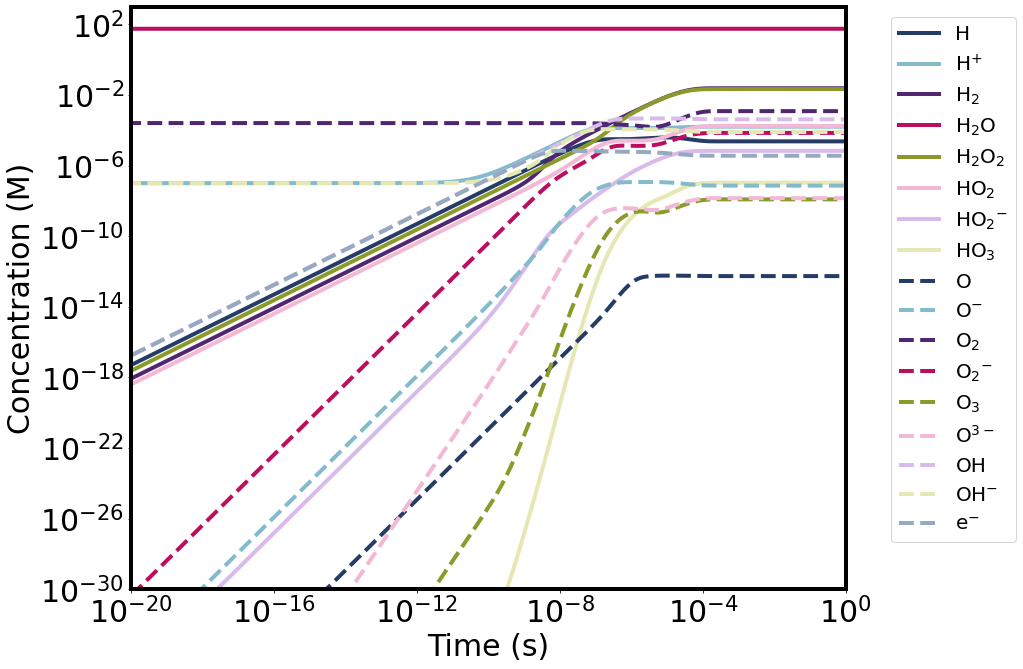

In [16]:
plt.figure(figsize=(15,10))

for x in range(len(concentrations)):
    #print(x)
    '''if any([reactants[x]=='H2O', reactants[x]=='H+', reactants[x]=='OH-']):
        linewidth=2
    else:
        linewidth=1'''
    if x<8:
        sns.lineplot(x=times, y=concentrations[x], label=reactant_labels[x], linewidth=4, color=colors[x])
    else:
        sns.lineplot(x=times, y=concentrations[x], label=reactant_labels[x], linestyle="dashed", linewidth=4, color=colors[x-8])
    #plt.plot(times,concentrations[x], label=reactant_labels[x], linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-20, 1)
plt.ylim(1e-30, 1000)
plt.xlabel('Time (s)')
plt.ylabel('Concentration (M)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()


In [194]:
print(concentrations.shape)
print(len(times))

(17, 619)
1813


### Plot NaCl Figure: 

Here I have opted to only include the products which reach above micromolar concentrations in these conditions as there are too many total reactants for the plot to look nice with all of them. 

22


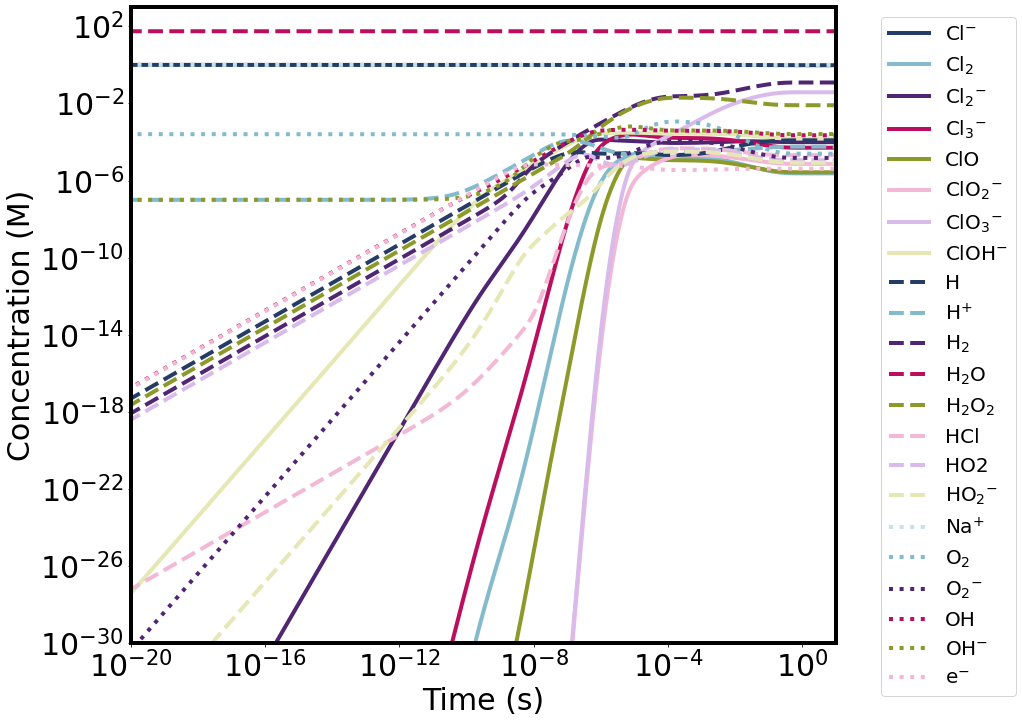

In [19]:
plt.figure(figsize=(15,11))
n=0
for x in range(len(concentrations_NaCl)):
    #print(x)
    '''if any([reactants[x]=='H2O', reactants[x]=='H+', reactants[x]=='OH-']):
        linewidth=2
    else:
        linewidth=1'''
    #if any([reactants_NaCl[x]=='H2O',reactants_NaCl[x]=='H+',reactants_NaCl[x]=='OH-',reactants_NaCl[x]=='Cl' ]):
    if concentrations_NaCl[x][-1]>1e-6:
        if reactants_NaCl[x]=='Na+':
            sns.lineplot(x=times, y=concentrations_NaCl[x], label=reactant_labels_NaCl[x], linewidth=4,linestyle="dotted",color=colors[-1])
        elif n<8:
            sns.lineplot(x=times, y=concentrations_NaCl[x], label=reactant_labels_NaCl[x], linewidth=4, color=colors[n])
        elif n<16:
            sns.lineplot(x=times, y=concentrations_NaCl[x], label=reactant_labels_NaCl[x], linewidth=4,linestyle="dashed",color=colors[n-8])
        else:
            sns.lineplot(x=times, y=concentrations_NaCl[x], label=reactant_labels_NaCl[x], linewidth=4,linestyle="dotted",color=colors[n-16])
        n+=1
    #else:
        #sns.lineplot(x=times, y=concentrations_NaCl[x], label=reactant_labels[x], linestyle="dashed", linewidth=4, color=colors[x-8])
    #plt.plot(times,concentrations[x], label=reactant_labels[x], linewidth=4)
print(n)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-20, 10)
plt.ylim(1e-30, 1000)
plt.xlabel('Time (s)')
plt.ylabel('Concentration (M)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()


In [156]:
print(len(reactants_NaCl))

39


In [118]:
print(reactants_NaCl)

['Cl', 'Cl-', 'Cl2', 'Cl2-', 'Cl2O', 'Cl2O2', 'Cl2O3', 'Cl2O4', 'Cl3-', 'ClO', 'ClO-', 'ClO2', 'ClO2-', 'ClO3', 'ClO3-', 'ClOH-', 'H', 'H+', 'H2', 'H2O', 'H2O2', 'HCl', 'HClO', 'HClO2', 'HO2', 'HO2-', 'HO3', 'Na', 'Na+', 'O', 'O-', 'O2', 'O2-', 'O3', 'O3-', 'O4', 'OH', 'OH-', 'eh-']


In [210]:
log_range = np.logspace(0,9, 50,base=10)
print(log_range)

[1.00000000e+00 1.52641797e+00 2.32995181e+00 3.55648031e+00
 5.42867544e+00 8.28642773e+00 1.26485522e+01 1.93069773e+01
 2.94705170e+01 4.49843267e+01 6.86648845e+01 1.04811313e+02
 1.59985872e+02 2.44205309e+02 3.72759372e+02 5.68986603e+02
 8.68511374e+02 1.32571137e+03 2.02358965e+03 3.08884360e+03
 4.71486636e+03 7.19685673e+03 1.09854114e+04 1.67683294e+04
 2.55954792e+04 3.90693994e+04 5.96362332e+04 9.10298178e+04
 1.38949549e+05 2.12095089e+05 3.23745754e+05 4.94171336e+05
 7.54312006e+05 1.15139540e+06 1.75751062e+06 2.68269580e+06
 4.09491506e+06 6.25055193e+06 9.54095476e+06 1.45634848e+07
 2.22299648e+07 3.39322177e+07 5.17947468e+07 7.90604321e+07
 1.20679264e+08 1.84206997e+08 2.81176870e+08 4.29193426e+08
 6.55128557e+08 1.00000000e+09]


## Plotting concentrations vs flux for some common reactant

Here I am performing the simulations with a number of different electron fluxs, and saving the steady-state concentrations of common substances (H+, OH-, eh, H2, O2, H2O2).

Only NaCl is shown here, however that can be easily changed  by  changing the reaction set and initial concentrations files. 

In [288]:
H = []
OH = [] 
eh = []
H2 = []
O2 = [] 
H2O2 =[]
reaction_set = 'H2O_NaCl.txt'
init_concentrations = 'C0_NaCl.txt'
setting_file = 'settings.txt'
log_range = list(np.logspace(-6,10, 50,base=10))

for x in log_range:
    setting_dct['e Flux']= x
    df, times, concentrations_NaCl, reactants_NaCl, setting_dct = execute_sims(reaction_set, \
                                                                               init_concentrations, setting_dct)
    hindex = reactants_NaCl.index('H+')
    ohindex = reactants_NaCl.index('OH-')
    ehindex = reactants_NaCl.index('eh-')
    h2index = reactants_NaCl.index('H2')
    O2index = reactants_NaCl.index('O2')
    H2O2index = reactants_NaCl.index('H2O2')
    
    H.append(concentrations_NaCl[hindex][-1])
    OH.append(concentrations_NaCl[ohindex][-1])
    eh.append(concentrations_NaCl[ehindex][-1])
    H2.append(concentrations_NaCl[h2index][-1])
    O2.append(concentrations_NaCl[O2index][-1])
    H2O2.append(concentrations_NaCl[H2O2index][-1])

H.insert(0,1e-7)
OH.insert(0,1e-7)
log_range.insert(0,0.00000001)
eh.insert(0, 0)

H2O2.insert(0,0)
H2.insert(0,0)
O2.insert(0, 2.55e-4)

ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Nothing found in line 14. Thus, it is ignored.
ERROR:root:Not

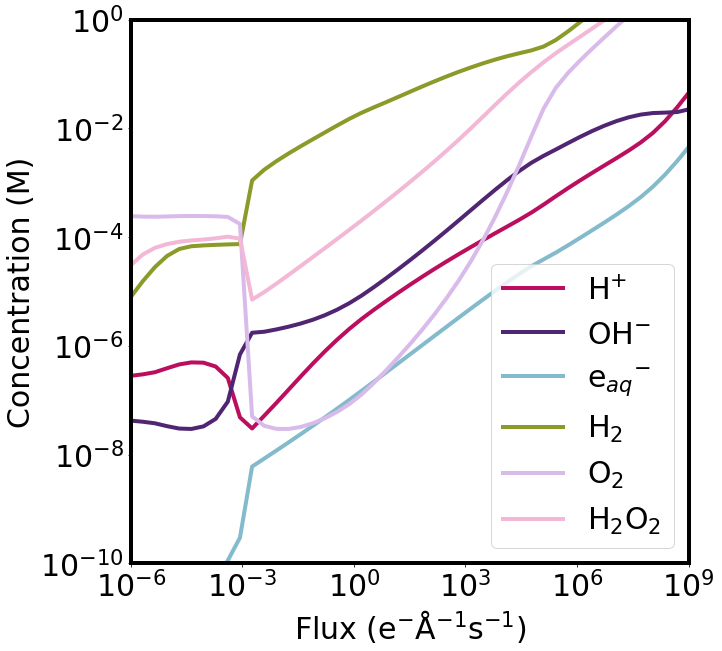

In [289]:
plt.figure(figsize=(10,10))

plt.plot(log_range, H, label='H$^{+}$', color='#BB0E5F')
plt.plot(log_range, OH, label='OH$^{-}$', color='#502673')
plt.plot(log_range, eh, label='e$_{aq}$$^{-}$', color='#83BACC')
plt.plot(log_range, H2, label='H$_{2}$', color = '#8B9A29')
plt.plot(log_range, O2, label='O$_{2}$', color= '#D8BBEA')
plt.plot(log_range, H2O2, label='H$_{2}$O$_{2}$',color='#F2B8D5')

 

#plt.axhline(1e-7)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-6, 1e9)
plt.ylim(1e-10, 1)
plt.xlabel('Flux (e$^{-}$Å$^{-1}$s$^{-1}$)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.show()